In [1]:
!pwd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# デフォルトは75%

import sys
sys.executable

/c/Users/shingo/jupyter_notebook/tfgpu_py36_work/02_keras_py/experiment


'C:\\Users\\shingo\\Anaconda3\\envs\\tfgpu20\\python.exe'

# multiclass model

#### 犬猫画像は以下のサイトから取得できた
- https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765


#### import

In [2]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, util
from model import tf_define_model as define_model
from model import tf_my_callback as my_callback
from model import tf_lr_finder as lr_finder
from transformer import tf_my_generator as my_generator
from transformer import tf_get_train_valid_test as get_train_valid_test
from predicter import tf_grad_cam as grad_cam
from predicter import tf_base_predict as base_predict
from predicter import roc_curve, conf_matrix, ensemble_predict

from tensorflow import keras
keras.backend.clear_session()

import glob, time, pathlib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# 75%

#### parameters

In [3]:
# 出力ディレクトリ
output_dir = r'D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test'
os.makedirs(output_dir, exist_ok=True)

# 入力ディレクトリ
train_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
train_samples = len(util.find_img_files(train_data_dir))

validation_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation'
val_samples = len(util.find_img_files(validation_data_dir))

test_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test'
test_samples = len(util.find_img_files(test_dir))

gpu_num = 0# "0,1,2,3"

# 分類クラス
class_name = sorted([str(pathlib.Path(dir_name).name) for dir_name in glob.glob(train_data_dir+'/*')])#['Cat', 'Dog']
classes = class_name
nb_classes = len(classes)

# エポック数、バッチサイズ
num_epoch = 2
batch_size = 50
val_batch_size = 50
test_batch_size = 50

# 入力層のサイズ
img_rows, img_cols, channels = 100, 100, 3

# finetuning model
choice_model = 'VGG16'#'EfficientNet'#'InceptionV3'
trainable = 15#249#'all'
is_skip_bn = True
model_path = None

# 全結合層
fcs = [256]
drop = 0.5
is_add_batchnorm = True#False
l2_rate = 1e-4

# optimizer
choice_optim='sgd'
lr = 0.1 * batch_size / 128
lr_factor = 0.01
    
# data augmentation
rescale = 1.0/255.0
#width_shift_range = 0.2
#height_shift_range = 0.2
horizontal_flip = True
#vertical_flip = True
#shear_range = 20
zoom_range_min = 0.8
zoom_range_max = 1.2
rotation_range = 20
channel_shift_range = 5.
brightness_range_min = 0.3
brightness_range_max = 1.0
mix_up_alpha = 0.2# mixup alpha
#random_crop = [224,224]# random_crop size
random_erasing_prob = 0.5 # random_erasing 確率
random_erasing_maxpixel = 255
ricap_beta = 0.3 # RICAP beta
ricap_use_same_random_value_on_batch = True # Trueとすれば論文と同じように「ミニバッチ間で共通の乱数を使う例」。Falseにすれば、「サンプル間で別々の乱数を使う例」
is_base_aug = True # 下山さんが使っていたAutoAugmentのデフォルト？変換入れるか

In [4]:
# my_IDG_optionsに値詰める。papermillで実行した時でもうまくいくようにする

gpus = str(gpu_num)
zoom_range = [zoom_range_min, zoom_range_max]
brightness_range = [brightness_range_min, brightness_range_max]

my_IDG_options = {}
if 'rescale' in list(locals().keys()):
    my_IDG_options['rescale'] = rescale
        
if 'width_shift_range' in list(locals().keys()):
    my_IDG_options['width_shift_range'] = width_shift_range
    
if 'height_shift_range' in list(locals().keys()):
    my_IDG_options['height_shift_range'] = height_shift_range
    
if 'horizontal_flip' in list(locals().keys()):
    my_IDG_options['horizontal_flip'] = horizontal_flip
    
if 'vertical_flip' in list(locals().keys()):
    my_IDG_options['vertical_flip'] = vertical_flip
    
if 'shear_range' in list(locals().keys()):
    my_IDG_options['shear_range'] = shear_range
    
if 'zoom_range' in list(locals().keys()):
    my_IDG_options['zoom_range'] = zoom_range
    
if 'rotation_range' in list(locals().keys()):
    my_IDG_options['rotation_range'] = rotation_range

if 'channel_shift_range' in list(locals().keys()):
    my_IDG_options['channel_shift_range'] = channel_shift_range

if 'brightness_range' in list(locals().keys()):
    my_IDG_options['brightness_range'] = brightness_range    

if 'mix_up_alpha' in list(locals().keys()):
    my_IDG_options['mix_up_alpha'] = mix_up_alpha
    
if 'random_erasing_prob' in list(locals().keys()):
    my_IDG_options['random_erasing_prob'] = random_erasing_prob
    
if 'random_erasing_maxpixel' in list(locals().keys()):
    my_IDG_options['random_erasing_maxpixel'] = random_erasing_maxpixel

if 'ricap_beta' in list(locals().keys()):
    my_IDG_options['ricap_beta'] = ricap_beta
    
if 'ricap_use_same_random_value_on_batch' in list(locals().keys()):
    my_IDG_options['ricap_use_same_random_value_on_batch'] = ricap_use_same_random_value_on_batch
    
if 'is_base_aug' in list(locals().keys()):
    my_IDG_options['is_base_aug'] = is_base_aug

#### data generator

In [5]:
def check_gen(gen):
    """ generatorの画像確認 """
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np
    %matplotlib inline
    x,y = next(gen)
    if isinstance(y, list):
        y = np.array(y)
    print(f"x.shape: {x.shape}")
    print(f"y.shape: {y.shape}")
    #print(f"y:\n{y}")
    print(f"y[0]: {y[0]}")
    util.plot_5imgs(x)
    return x,y

In [6]:
d_cls = get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                            , batch_size, valid_batch_size=val_batch_size, test_batch_size=test_batch_size
                                            , train_samples=train_samples, valid_samples=val_samples, test_samples=test_samples)

d_cls.create_my_generator_flow_from_directory(train_data_dir
                                              , classes
                                              , valid_data_dir=validation_data_dir
                                              , test_data_dir=test_dir
                                              , color_mode='rgb'
                                              , class_mode='categorical'
                                              , my_IDG_options=my_IDG_options
                                              , is_valid_grayscale=False # validation generatorをグレースケール化するか
                                             )

train_steps_per_epoch : 20
valid_steps_per_epoch : 8
test_steps_per_epoch : 1
my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'zoom_range': [0.8, 1.2], 'rotation_range': 20, 'channel_shift_range': 5.0, 'brightness_range': [0.3, 1.0], 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True, 'is_base_aug': True}
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


(<generator object MyImageDataGenerator.flow_from_directory at 0x0000014E283E1CC8>,
 <keras_preprocessing.image.directory_iterator.DirectoryIterator at 0x14e284c9808>)

Found 1000 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


x.shape: (50, 100, 100, 3)
y.shape: (50, 2)
y[0]: [0.1882013 0.8117987]
Num_Images:  50


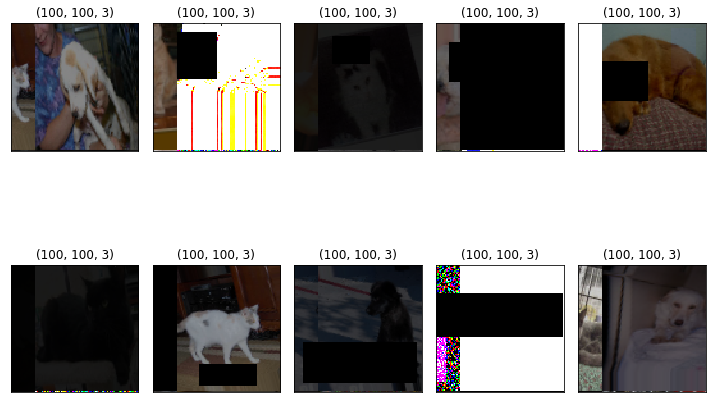

<Figure size 432x288 with 0 Axes>

In [7]:
x,y = check_gen(d_cls.train_gen)

x.shape: (50, 100, 100, 3)
y.shape: (50, 2)
y[0]: [1. 0.]
Num_Images:  50


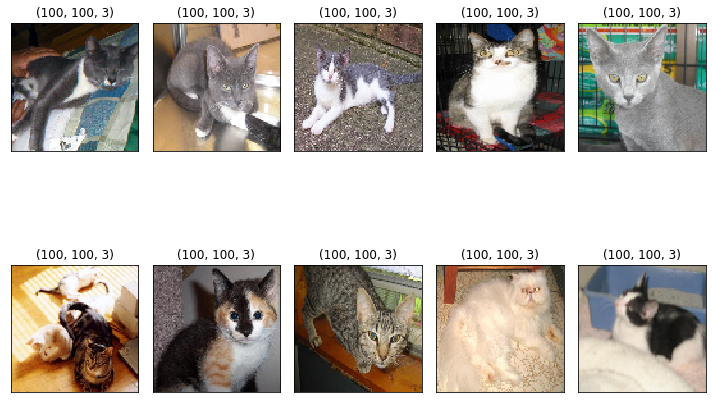

<Figure size 432x288 with 0 Axes>

In [8]:
x,y = check_gen(d_cls.valid_gen)

x.shape: (50, 100, 100, 3)
y.shape: (50, 2)
y[0]: [1. 0.]
Num_Images:  50


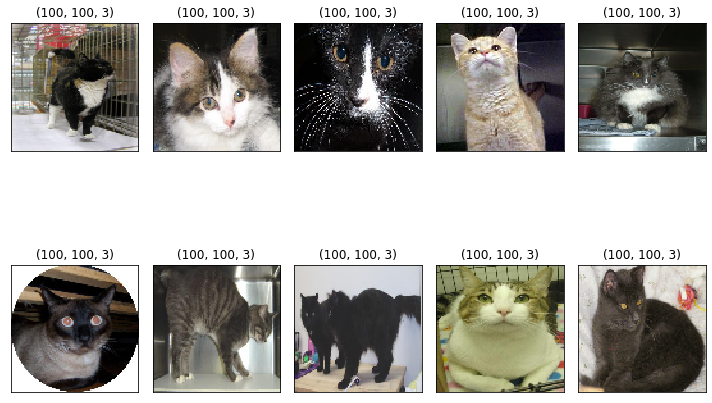

<Figure size 432x288 with 0 Axes>

In [9]:
x,y = check_gen(d_cls.test_gen)

#### model

In [10]:
# loss
loss = 'categorical_crossentropy'
metrics = ['accuracy']
activation = 'softmax'

# model
if model_path is None:
    if trainable != 'all':
        trainable = int(trainable)
    model, orig_model = define_model.get_fine_tuning_model(output_dir, img_rows, img_cols, channels
                                                           , len(classes)
                                                           , choice_model, trainable
                                                           , fcs=fcs, drop=drop
                                                           , is_add_batchnorm=is_add_batchnorm
                                                           , l2_rate=l2_rate
                                                           , activation=activation
                                                           , gpu_count=len(gpus.split(','))
                                                           , skip_bn=is_skip_bn
                                                          )
else:
    model = keras.models.load_model(model_path, compile=False)
    
optim = define_model.get_optimizers(choice_optim, lr=lr)
model.compile(loss=loss, optimizer=optim, metrics=metrics)

----- model_param -----
output_dir = D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test
img_rows img_cols channels = 100 100 3
num_classes = 2
choice_model trainable = VGG16 15
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True


In [11]:
define_model.print_model_summary(model)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

useGen: True
Epoch 1/103
20/20 [==============================] - 12s 616ms/step - loss: 0.7444 - accuracy: 0.4890
Epoch 2/103
20/20 [==============================] - 12s 591ms/step - loss: 0.7444 - accuracy: 0.5290
Epoch 3/103
20/20 [==============================] - 12s 588ms/step - loss: 0.7444 - accuracy: 0.4910
Epoch 4/103
20/20 [==============================] - 12s 589ms/step - loss: 0.7444 - accuracy: 0.4740
Epoch 5/103
20/20 [==============================] - 12s 597ms/step - loss: 0.7444 - accuracy: 0.4980
Epoch 6/103
20/20 [==============================] - 12s 615ms/step - loss: 0.7444 - accuracy: 0.5020
Epoch 7/103
20/20 [==============================] - 12s 595ms/step - loss: 0.7444 - accuracy: 0.5030
Epoch 8/103
20/20 [==============================] - 12s 593ms/step - loss: 0.7444 - accuracy: 0.5170
Epoch 9/103
20/20 [==============================] - 12s 618ms/step - loss: 0.7444 - accuracy: 0.5140
Epoch 10/103
20/20 [==============================] - 12s 603ms/step 

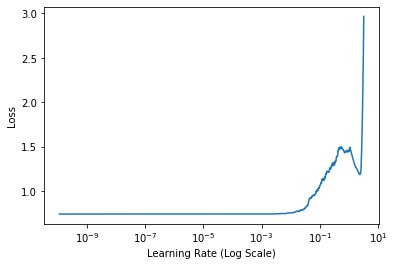

In [12]:
# 最適な学習率探索. 後続処理実行する場合はデータとモデル再定義必要
#lr_finder.run(model, d_cls.train_gen, batch_size, d_cls.init_train_steps_per_epoch, output_dir=output_dir)

#### train

Epoch 1/2
19/20 [===========================>..] - ETA: 0s - loss: 0.7771 - accuracy: 0.4947
Epoch 00001: val_loss improved from inf to 0.76531, saving model to D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\val_loss_best.h5

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\val_accuracy_best.h5
20/20 [==============================] - 14s 696ms/step - loss: 0.7753 - accuracy: 0.5000 - val_loss: 0.7653 - val_accuracy: 0.5000
Epoch 2/2
19/20 [===========================>..] - ETA: 0s - loss: 0.9146 - accuracy: 0.4495
Epoch 00002: val_loss improved from 0.76531 to 0.74397, saving model to D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\val_loss_best.h5

Epoch 00002: val_accuracy did not improve from 0.50000
20/20 [==============================] - 12s 620ms/step - loss: 0.9161 - accuracy: 0.4510 - val_loss: 0.7440 - val_accuracy: 0.5000
Elapsed Time : 26.36sec


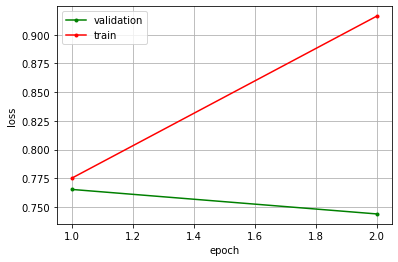

<Figure size 432x288 with 0 Axes>

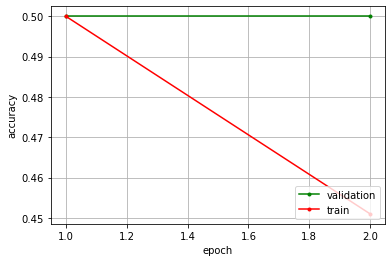

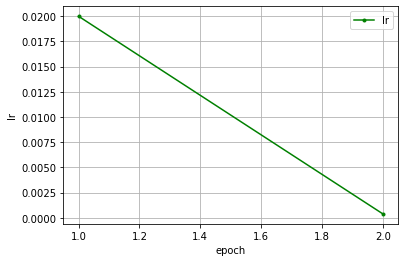

<Figure size 432x288 with 0 Axes>

In [12]:
def get_cb(output_dir:str, num_epoch:int) -> list:
    """ trainでつかうkerasのcallback取得 """
    cb = []
    # 学習率をエポック増やすごとにコサインカーブで上げ下げする. epochsはコサインカーブのほぼ半周期になるエポック数
    cb.append(my_callback.cosine_annealing(factor=lr_factor, epochs=num_epoch))
    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'val_loss_best.h5'), monitor='val_loss', save_best_only=True, verbose=1))
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'val_accuracy_best.h5'), monitor='val_accuracy', save_best_only=True, verbose=1, mode='max'))
    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=num_epoch//2, verbose=1))
    return cb

start_time = time.time()
history = model.fit_generator(
    d_cls.train_gen
    , steps_per_epoch = train_samples//batch_size
    , epochs = num_epoch
    , validation_data = d_cls.valid_gen
    , validation_steps = val_samples//val_batch_size
    , verbose = 1 # 1:ログをプログレスバーで標準出力 2:最低限の情報のみ出す
    , callbacks = get_cb(output_dir, num_epoch)
    )
end_time = time.time()
print("Elapsed Time : {:.2f}sec".format(end_time - start_time))

# lossやaccの学習履歴のグラフ保存
plot_log.plot_results(output_dir, os.path.join(output_dir, 'tsv_logger.tsv'), acc_metric=metrics[0])

#### predict

,Filename,PredictionLabel,PredictionScore
0,Cat\10024.jpg,Dog,0.537
1,Cat\10046.jpg,Dog,0.549
2,Cat\10070.jpg,Dog,0.54
3,Cat\10122.jpg,Dog,0.532
4,Cat\10136.jpg,Dog,0.531


y_pred_list_str: ['Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Do

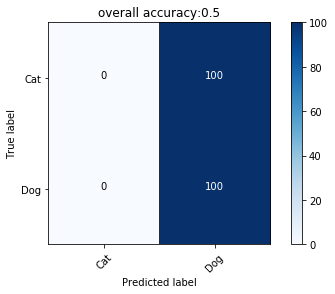

<Figure size 432x288 with 0 Axes>

In [13]:
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
#load_model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5'), custom_objects={'lr':lr_metric})
load_model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5'))

# generatorで全件予測
pred_df = base_predict.pred_classes_generator(load_model, d_cls.test_gen, classes_list=class_name)
pred_df.to_csv(os.path.join(output_dir, 'pred.tsv'), sep='\t')
display(pred_df.head())

# 予測結果のデータフレームから混同行列作成
base_predict.conf_matrix_from_pred_classes_generator(pred_df, classes, output_dir)

#### Grad-CAM

In [14]:
out_grad_cam_dir = os.path.join(output_dir, 'grad_cam/test')
os.makedirs(out_grad_cam_dir, exist_ok=True)

for i,p in tqdm(enumerate(util.find_img_files(test_dir))):
                
    # 50枚ごとにモデル再ロード
    if i % 50 == 0:
        keras.backend.clear_session() # セッションのクリア
        keras.backend.set_learning_phase(0) # Test時には0にセット DropoutやBatchNormありmodelのときはロード前にこれがないとGradCamエラーになる
        model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5'), compile=False) # モデルロード
    
    grad_cam_img = grad_cam.image2gradcam(model, p, out_dir=out_grad_cam_dir, is_gradcam_plus=False)


out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10024_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10046_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10070_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10122_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10136_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10141_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10185_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10283_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf

out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/6260_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/6294_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/6321_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/6403_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/6412_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/7082_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/7351_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/7458_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS

out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/3442_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/3812_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/401_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/4075_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/4234_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/4304_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/4483_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/4484_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS.

Num_Images:  252


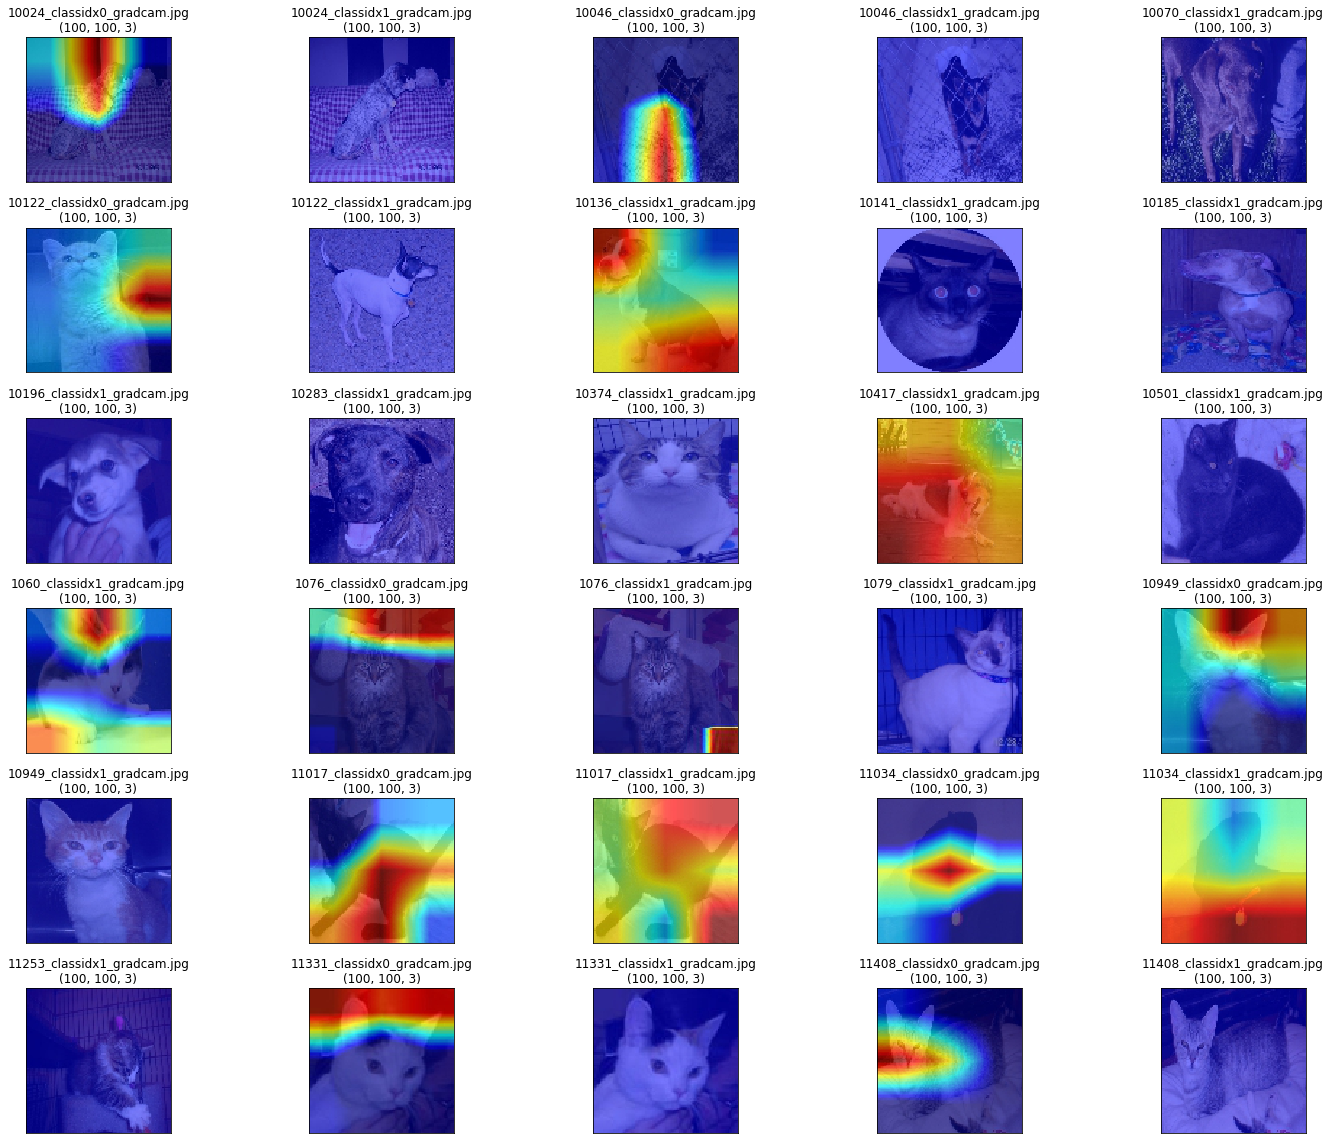

<Figure size 432x288 with 0 Axes>

In [15]:
img_list = glob.glob(out_grad_cam_dir+'/*.jpg')
num = 30
util.plot_5imgs(img_list
                , plot_num=num
                , figsize=(10*2, 8*2)
                , labels=[str(pathlib.Path(p).name) for p in img_list[:num]])